In [76]:
import numpy as np
import sys, os, shutil
import pandas as pd
import collections as cl
import itertools as it
import timeit
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy as cp
import umap
#Change directory
os.chdir("C:/Users/yche465/Desktop/CS570/Project")
os.getcwd()


'C:\\Users\\yche465\\Desktop\\CS570\\Project'

In [77]:
#Import PDC dataset
PDC = np.loadtxt('PDC.txt', usecols=range(103), delimiter=",")

In [78]:
#Import the dataframe object with the three selected features (made in the jupyter notebook entitled "Pre-processing")
import pickle
pickle_in=open("UnSTD_DATA","rb")
loadobj=pickle.load(pickle_in)
Data=loadobj

### Preliminary Data Exploration

In [79]:
#Categorical distribution of number of PrEP prescription interval
freq=dict(cl.Counter(Data[:,1]))
df = pd.DataFrame(list(freq.items()),columns = ['Number of PrEP interval','N']) 
df

,Number of PrEP interval,N
0,1,102853
1,2,38591
2,3,13613
3,4,4088
4,5,1238
5,6,268
6,7,69
7,8,18
8,9,1


Text(0.5, 1.025, 'Distribution of the total duration in PrEP cessation ')

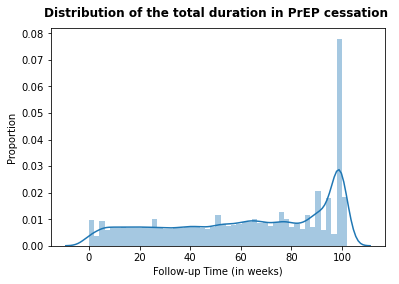

In [80]:
#Distribution of the total duration spent in PrEP cessation
ax=sns.distplot(Data[:,0])
ax.set(xlabel="Follow-up Time (in weeks)", ylabel="Proportion")
ax.set_title("Distribution of the total duration in PrEP cessation ",fontweight='bold', y=1.025)

Text(0.5, 1.025, 'Distribution of the timings of the first PrEP cessation ')

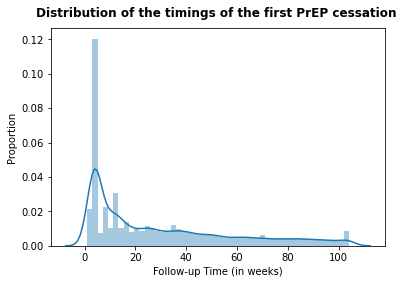

In [81]:
#Distribution of the timings of the first PrEP cessation
ax=sns.distplot(Data[:,2])
ax.set(xlabel="Follow-up Time (in weeks)", ylabel="Proportion")
ax.set_title("Distribution of the timings of the first PrEP cessation ",fontweight='bold', y=1.025)

### K-Means clustering based on the critical features extracted from the time series data

In [82]:
from sklearn.manifold import TSNE
from sklearn import preprocessing as prep
#standardize variables
tData=np.sqrt(Data)
scaler = prep.StandardScaler().fit(tData)
scaled_data = scaler.transform(tData)
#Make into dataframe
SDATA=pd.DataFrame(scaled_data, columns = ["Cessation Time","PrEP intervals","1st Cessation"])
SDATA['ID']=np.array(range(len(Data)))

In [83]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
SIL=[]
DB=[]
CAL=[]
DUNN=[]
#Implement loop for implementing k-means algorithm at various k values and generating corresponding cluster validation indices
for k in range(2,5):
    #k-means
    km = KMeans(n_clusters=k, random_state=0,init="k-means++").fit(scaled_data)
    cluster_labels=km.fit_predict(scaled_data)
    SDATA['Label']=km.fit_predict(scaled_data)
    #cluster validation: silhouette
    SL_avg = silhouette_score(scaled_data, cluster_labels)
    SIL.append(SL_avg)
    #cluster validation: DB
    DB_avg=davies_bouldin_score(scaled_data, cluster_labels)
    DB.append(DB_avg)
    #cluster validation: calinski
    Cal_avg=metrics.calinski_harabasz_score(scaled_data, cluster_labels)
    CAL.append(Cal_avg)

In [84]:
# Display the cluster quality indices by k values
clusterVal=pd.DataFrame(np.array(range(2,5)),columns=["K"])
clusterVal["Silhouette Index"]=SIL
clusterVal["Davies-Bouldin index"]=DB
clusterVal["Calinski-Harabasz index"]=CAL
clusterVal

,K,Silhouette Index,Davies-Bouldin index,Calinski-Harabasz index
0,2,0.429105,1.023050,121346.271051
1,3,0.487677,0.817531,164221.077949
2,4,0.490427,0.718599,163824.404145


In [24]:
#Extract stage-I cluster label data and export it as pickle file 
S1Members=[]
for i in range(4):
    c=SDATA[SDATA.Label==i]['ID'].values
    S1Members.append(c)


In [85]:
# Create PDC time series matrix grouped by stage-I cluster membership
PDC_S1=[]
for i in range(4):
    temp=PDC[SDATA[SDATA.Label==i]['ID'].values]
    PDC_S1.append(temp)

# # Export the PDC time series (by stage-I cluster membership) as pickle file for later use
# import pickle
# pickle_out=open("PDC_S1","wb")
# pickle.dump(PDC_S1,pickle_out)
# pickle_out.close()


In [91]:
#Extract stage-I cluster label sample data(sample size=15%) and export it as pickle file 
np.random.seed(0)
samplesize=[np.int(0.15*len(PDC_S1[i])) for i in range(len(PDC_S1))]
S1Members_selected=[]
for i in range(len(PDC_S1)):
    selected=np.random.choice(len(PDC_S1[i]),samplesize[i])
    s=S1Members[i][selected]
    S1Members_selected.append(s)

# import pickle
# pickle_out=open("S1Members_15","wb")
# pickle.dump(S1Members_selected,pickle_out)
# pickle_out.close()    

In [98]:
#Relative frequencies of Stage-I cluster label
a=[len(PDC_S1[i]) for i in range(4)]
b=sum(np.array(a))
prop=np.array(a)/b
pd.DataFrame(prop.reshape((1,4)), columns=["Cluster A","Cluster B", "Cluster C", "Cluster D"])

,Cluster A,Cluster B,Cluster C,Cluster D
0,0.301514,0.177704,0.316158,0.204624


### Visualize k-mean clusters on UMAP

In [102]:
#Create Stage-I Cluster label (i.e., A,B,C,D)
conditions=[SDATA["Label"]==0,SDATA["Label"]==1,SDATA["Label"]==2,SDATA["Label"]==3]
values=["A","B","C","D"]
SDATA["Label2"]=np.select(conditions,values)

In [104]:
#Sample 25% of the entire dataset for UMAP
np.random.seed(0)
selected=np.random.choice(len(PDC),np.rint(0.25*len(PDC)).astype(int))

In [105]:
vsample=SDATA[['Cessation Time','PrEP intervals','1st Cessation']].loc[selected]
vsample_label=SDATA[['Label2']].loc[selected]

In [106]:
mapper = umap.UMAP(random_state=0,n_components=2).fit(vsample)

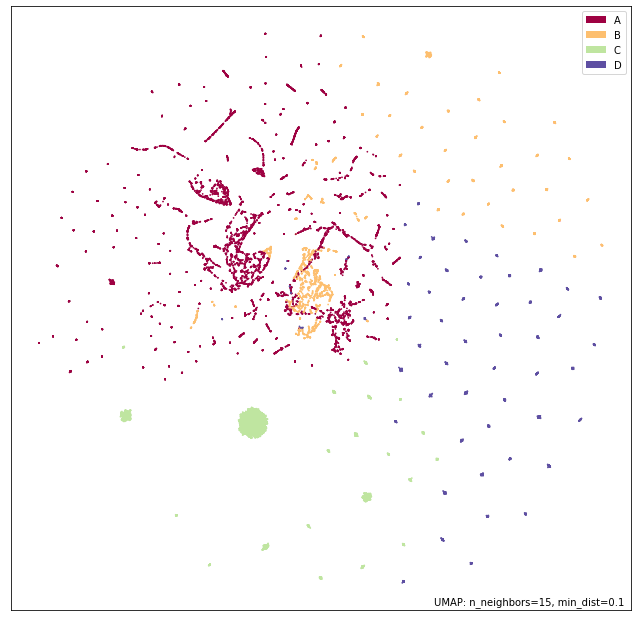

In [107]:
import umap.plot
umap.plot.points(mapper, labels=vsample_label.values.ravel())

### Visualize cluster-specific PDC trend by stage-I cluster membership

In [108]:
#Sample 15% of the PDC time series from each stage-I cluster for graphing purpose
PDC_S1=[]
for i in range(4):
    temp=PDC[SDATA[SDATA.Label==i]['ID'].values]
    PDC_S1.append(temp)

samplesize=[np.int(0.15*len(PDC_S1[i])) for i in range(len(PDC_S1))]

PDC_S1_sample=[]
for i in range(len(PDC_S1)):
    selected=np.random.choice(len(PDC_S1[i]),samplesize[i])
    s= PDC_S1[i][selected]
    PDC_S1_sample.append(s)

In [113]:
#graphing helper function
label=["A","B","C","D"]
def plotstuff(j,ax):
    for i in range(len(PDC_S1_sample[j])):
    #for i in range(200):
        ax.plot(Week, PDC_S1_sample[j][i], "blue", linewidth=1, alpha=0.006)
    ax.set_xlabel("Follow-up Time (Weeks)",fontsize=12)
    ax.set_ylabel("PDC",fontsize=12)
    ax.text(x=0, y=1.025, s=f"Cluster {label[j]}", fontsize=10, transform=ax.transAxes)

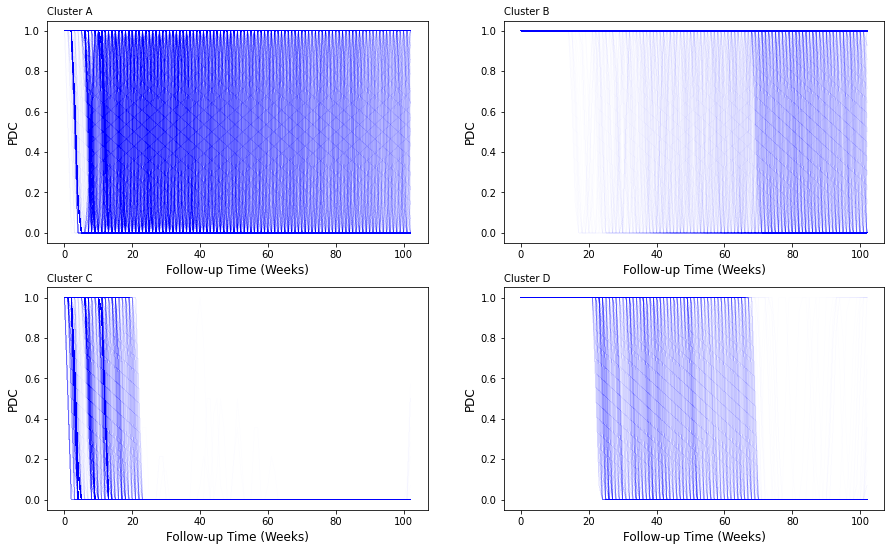

In [114]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15, 9))
Week=np.arange(0,103)

plotstuff(0,ax1)
plotstuff(1,ax2)
plotstuff(2,ax3)
plotstuff(3,ax4)